In [ ]:
# import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ProjectFakeNews/processed_fake_news.csv') # load the prepocessed dataset

In [ ]:
df.head()

,Unnamed: 0,text,label,lemm_sent,rephrased,joined_lemm
0,0,No comment is expected from Barack Obama Membe...,1,"['comment', 'expect', 'barack', 'obama', 'memb...","['comment', 'expect', 'barack_obama', 'member'...",comment expect barack_obama member fyf911 fuky...
1,1,Did they post their votes for Hillary already?,1,"['post', 'vote', 'hillary']","['post', 'vote_hillary']",post vote_hillary
2,2,"Now, most of the demonstrators gathered last ...",1,"['demonstrator', 'gather', 'night', 'exercise'...","['demonstrator_gather', 'night', 'exercise_con...",demonstrator_gather night exercise_constitutio...
3,3,A dozen politically active pastors came here f...,0,"['dozen', 'politically', 'active', 'pastor', '...","['dozen', 'politically_active', 'pastor', 'com...",dozen politically_active pastor come private_d...
4,4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,"['rs-28', 'sarmat', 'missile', 'dub', 'satan',...","['rs-28_sarmat', 'missile_dub', 'satan_2', 're...",rs-28_sarmat missile_dub satan_2 replace_ss-18...


In [ ]:
df['lemm_sent'] = df.lemm_sent.apply(lambda x: eval(x)) 
# convert the lemm_sent colum back to list, as it is saved as a string.

In [ ]:
df['lemm_sent'] = df['lemm_sent'].apply(lambda x: ' '.join([str((i)) for i in x]))
# join the tokens to make a sentence

In [ ]:
df.head()

,Unnamed: 0,text,label,lemm_sent,rephrased,joined_lemm
0,0,No comment is expected from Barack Obama Membe...,1,comment expect barack obama member fyf911 fuky...,"['comment', 'expect', 'barack_obama', 'member'...",comment expect barack_obama member fyf911 fuky...
1,1,Did they post their votes for Hillary already?,1,post vote hillary,"['post', 'vote_hillary']",post vote_hillary
2,2,"Now, most of the demonstrators gathered last ...",1,demonstrator gather night exercise constitutio...,"['demonstrator_gather', 'night', 'exercise_con...",demonstrator_gather night exercise_constitutio...
3,3,A dozen politically active pastors came here f...,0,dozen politically active pastor come private d...,"['dozen', 'politically_active', 'pastor', 'com...",dozen politically_active pastor come private_d...
4,4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,rs-28 sarmat missile dub satan 2 replace ss-18...,"['rs-28_sarmat', 'missile_dub', 'satan_2', 're...",rs-28_sarmat missile_dub satan_2 replace_ss-18...


In [ ]:
texts = df['lemm_sent']
labels = df['label']

print('Found %s texts.' %texts.shape[0])

Found 72134 texts.


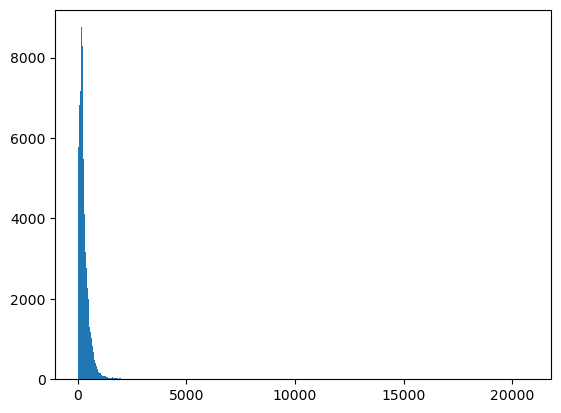

count    72134.000000
mean       289.334475
std        324.090027
min          1.000000
25%        125.000000
50%        218.000000
75%        361.000000
max      20759.000000
Name: lemm_sent, dtype: float64

In [ ]:
#plot to see what number of words each sentences have.
# the distribution is very skewed, 75% of the sentences have only around 361 words.
texts = texts.apply(lambda x: str(x))
text_lengths = texts.apply(lambda x: len(x.split(" ")))
plt.hist(text_lengths,bins=500)
plt.show()
pd.Series(text_lengths).describe()

In [ ]:
# function to plot the AUC-ROC curve and the test and AUC score.
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,classification_report,roc_curve



def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing accuraries are reported
    '''
    # training acc
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)
    
    # testing acc
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test,y_predict_test)
    

    # accuracy = accuracy_score(y_test,y_pred_tex)
    roc_auc =roc_auc_score(y_test, y_predict_test)
    precision = precision_score(y_pred=y_predict_test, y_true=y_test,zero_division=1)
    recall = recall_score(y_pred=y_predict_test, y_true=y_test,zero_division=1)
    
    cr = classification_report(y_test, y_predict_test,zero_division=1)


    fpr, tpr, threshold = roc_curve(y_test, y_predict_test)
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr, label= 'Model')
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12)
    plt.title('ROC Curve',fontsize=20)
    plt.legend(fontsize=12)
    plt.show()

    roc_auc_sc = roc_auc_score(y_test,y_predict_test)

    return train_acc, test_acc,cr,roc_auc_sc

In [ ]:
# preprocesor to tokenize and zero pad the sentences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

In [ ]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 1000
EMBEDDING_DIM = 256
TEST_SPLIT = 0.2

In [ ]:
# tokenizing sentences into words 
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
# using fit_on_texts method assigning values to particular words
tokenizer.fit_on_texts(texts)
# texts_to_sequences method is used to give particular integer values to word
sequences = tokenizer.texts_to_sequences(texts)

# calculating word_index
word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
# padding data to the same length for each samples
data = pad_sequences(sequences, 
                     maxlen=MAX_SEQUENCE_LENGTH, 
                     padding='post', 
                     truncating='post')
print(len(word_index))
print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

233928
Found 233928 unique tokens.
Shape of data tensor: (72134, 1000)
Shape of label tensor: (72134,)


In [ ]:
# split to get test,train and val data
from sklearn.model_selection import train_test_split



x, x_test, y, y_test = train_test_split(data, 
                                        labels, 
                                        test_size=0.2)

x_train, x_val, y_train, y_val = train_test_split(x,
                                                  y, 
                                                  test_size=0.1)

print('train size:',x_train.shape[0])
print('test size:', x_test.shape[0])

train size: 51936
test size: 14427


In [ ]:
# building the model                                                                      

from keras import layers
from keras.models import Sequential

dropout = 0.4
model = Sequential()

# defining embedding layer where embedding dimension/ vector size is defined as 256 and input length is set as 1000. 
#Where MAX_NUM_WORDS are unique words.
model.add(layers.Embedding(MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, trainable=False))
# defining a convolution layer, number of filters are set as 128 and kernal size is defined as 1 X 5.
model.add(layers.Conv1D(128,5, activation='ReLU'))
# maxpooling1d layer is used to take maximum values from representation.
model.add(layers.MaxPool1D(2))
# adding a dropout of 0.4
model.add(layers.Dropout(dropout))
# defining a convolution layer, number of filters are set as 64 and kernal size is defined as 1 X 3.
model.add(layers.Conv1D(64,3, activation='ReLU'))
# maxpooling1d layer is used to take maximum values from representation.
model.add(layers.MaxPooling1D(2, strides= 2))
# defining an LSTM layer with 64 units
model.add(layers.LSTM(64,return_sequences=True))
# defining an LSTM layer with 32 units
model.add(layers.LSTM(32,return_sequences=True))
# adding a flattening layer
model.add(layers.Flatten())

# dense layer with 64 neurons and ReLu activation function
model.add(layers.Dense(64, activation='ReLU'))
# dropout of 0.4
model.add(layers.Dropout(dropout))
# dense layer with 16 neurons and ReLu activation function
model.add(layers.Dense(16, activation='ReLU'))
# output layer with 1 neuron and sigmoid activation for binary classification
model.add(layers.Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary() # summary of the model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 256)         256000    
                                                                 
 conv1d_2 (Conv1D)           (None, 996, 128)          163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 498, 128)         0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 498, 128)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 496, 64)           24640     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 248, 64)          0         
 1D)                                                  

In [ ]:
# train the model
import time as t
start = t.time()
history = model.fit(x_train, 
                    y_train,
                    batch_size=128,initial_epoch=0,
                    epochs=15,validation_data=(x_val, y_val))

print("total training time:",t.time()-start)

Epoch 1/15
406/406 [==============================] - 34s 81ms/step - loss: 0.2673 - accuracy: 0.8768 - val_loss: 0.1039 - val_accuracy: 0.9600
Epoch 2/15
406/406 [==============================] - 32s 79ms/step - loss: 0.1052 - accuracy: 0.9623 - val_loss: 0.0832 - val_accuracy: 0.9705
Epoch 3/15
406/406 [==============================] - 32s 79ms/step - loss: 0.0788 - accuracy: 0.9721 - val_loss: 0.0704 - val_accuracy: 0.9750
Epoch 4/15
406/406 [==============================] - 33s 80ms/step - loss: 0.0560 - accuracy: 0.9812 - val_loss: 0.0786 - val_accuracy: 0.9738
Epoch 5/15
406/406 [==============================] - 32s 79ms/step - loss: 0.0436 - accuracy: 0.9857 - val_loss: 0.0668 - val_accuracy: 0.9757
Epoch 6/15
406/406 [==============================] - 32s 79ms/step - loss: 0.0364 - accuracy: 0.9878 - val_loss: 0.0898 - val_accuracy: 0.9685
Epoch 7/15
406/406 [==============================] - 32s 78ms/step - loss: 0.0291 - accuracy: 0.9901 - val_loss: 0.0787 - val_accuracy:

In [ ]:
# plot training and validation accuracy / loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy / Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss','Training Accuracy','Validation Accuracy'])
plt.show()

In [ ]:
# evaluate the model
print("Evaluate on test data")
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
451/451 [==============================] - 7s 15ms/step - loss: 0.0980 - accuracy: 0.9769
test loss, test acc: [0.09797324240207672, 0.9769182801246643]


451/451 [==============================] - 6s 12ms/step


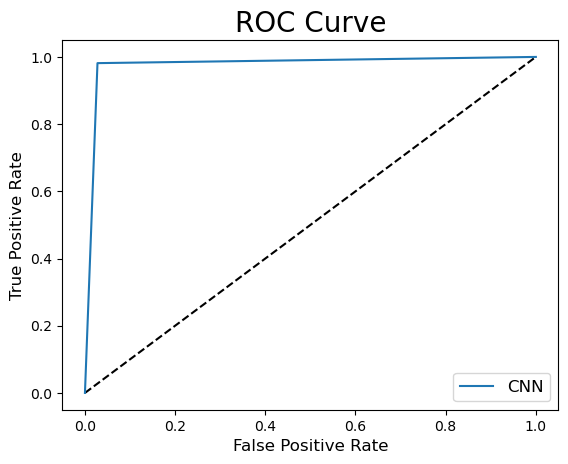

Training Accuracy: 99.93%
Testing Accuracy: 97.69%
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      7124
           1       0.97      0.98      0.98      7303

    accuracy                           0.98     14427
   macro avg       0.98      0.98      0.98     14427
weighted avg       0.98      0.98      0.98     14427

AUC score 0.9768605358046655
Total time required for testing 26.00427532196045


In [ ]:
# plot the ROC Curve and find the AUC score
import time as t
start = t.time()
train_acc, test_acc,cr,roc_auc_sc = evaluate_model(lambda x: np.rint(model.predict(x)),
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))
print("Classification Report:\n",cr)
print("AUC score",roc_auc_sc)
print("Total time required for testing",t.time()-start)